In [1]:
# Import necessary libraries
using AlgebraicRelations.ACSetDB, AlgebraicRelations.ACSetQueries, AlgebraicRelations.ACSetInterface;

┌ Info: Precompiling AlgebraicRelations [1c3ea84b-a956-4dfe-a2f4-485757f48f1d]
└ @ Base loading.jl:1278


## Define the Schema
We need to define the data types, the table column names, and the syntax of our schema

In [2]:
@present WorkplaceSchema <: TheorySQL begin
    # Data tables
    employees::Ob
    employees_1_person::Attr(employees, Int64)
    employees_2_id::Attr(employees, Int64)
    
    names::Ob
    names_1_person::Hom(names, employees)
    names_2_full_name::Attr(names, String)
    
    salary::Ob
    salary_1_person::Hom(salary, employees)
    salary_2_salary::Attr(salary, Float64)
    
    # Relation tables
    manager::Ob
    manager_1_person::Hom(manager, employees)
    manager_2_manager::Hom(manager, employees)
    
    relation::Ob
    relation_1_person1::Hom(relation, employees)
    relation_2_person2::Hom(relation, employees)
    relation_3_relationship::Attr(relation, Float64)
end;

Workplace = SchemaType(WorkplaceSchema);
schema = Workplace();

In [3]:
print(generate_schema_sql(schema));

CREATE TABLE manager (person int, manager int);
CREATE TABLE employees (person int, id int);
CREATE TABLE names (person int, full_name text);
CREATE TABLE salary (person int, salary float4);
CREATE TABLE relation (person1 int, person2 int, relationship float4)

## Generate the Query
We are now able to generate queries based off of this schema which we defined.

SELECT t1.full_name AS emp_name, t2.salary AS salary
FROM names AS t1, salary AS t2
WHERE t2.person=t1.person AND t2.salary<=$2 AND t2.salary>=$1

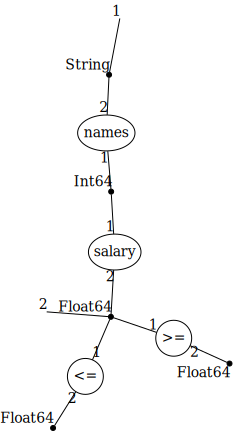

In [4]:
# We generate a query that gets all employees make a salary within some range
q1 = @query schema (emp_name, salary) where 
                          (p::Int64, emp_name::String, 
                           salary::Float64, 
                           _slower::Float64, _supper::Float64) begin                       
  # Define name relationships
  names(p, emp_name)
  
  # Define salary relationships (with input range)
  salary(p,salary)
  <=(salary, _supper)
  >=(salary, _slower)
end;
print(to_sql(q1))
draw_query(q1)

SELECT t1.full_name AS emp_name, t2.full_name AS man_name, t4.salary AS salary
FROM names AS t1, names AS t2, manager AS t3, salary AS t4
WHERE t3.person=t1.person AND t3.manager=t2.person AND t4.person=t2.person AND t4.salary<=$2 AND t4.salary>=$1

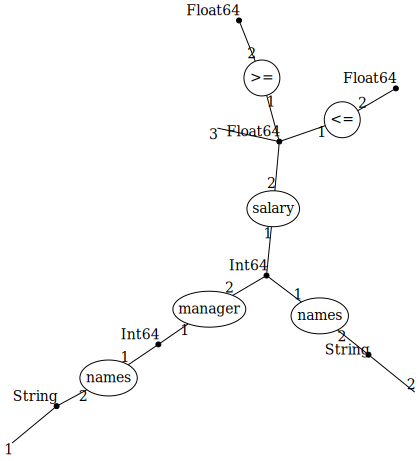

In [5]:
# We generate a second query that gets all employees whose managers make a salary within some range
q2 = @query schema (emp_name, man_name,salary) where 
                          (p::Int64, m::Int64, emp_name::String, 
                           man_name::String, salary::Float64, 
                           _slower::Float64, _supper::Float64) begin                       
  # Define name relationships
  names(p, emp_name)
  names(m, man_name)
  
  # Define manager relationships
  manager(p,m)
    
  # Define salary relationships (with input range)
  salary(m,salary)
  <=(salary, _supper)
  >=(salary, _slower)
end;
print(to_sql(q2))
draw_query(q2)

In [6]:
conn = Connection("dbname=test_emp");

In [7]:
statement1 = prepare(conn,q1);
statement2 = prepare(conn, q2);

In [8]:
execute(statement1, [0, 200000])

,emp_name,salary
,String?,Float32?
1,Alice Smith,150000.0
2,Bob Jones,50000.0
3,Eve Johnson,80000.0
4,John Doe,90000.0


In [9]:
execute(statement2, [60000, 100000])

,emp_name,man_name,salary
,String?,String?,Float32?
1,Eve Johnson,John Doe,90000.0


In [10]:
close(conn)